# Statistics 4: Multivariate Models and Choosing the Best Model

Import Necessary Modules and Read Necessary CSV Files

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import sklearn.cross_validation as cv
%matplotlib inline


salaries = pd.read_csv("core/Salaries.csv")
hits = pd.read_csv("core/Batting.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 5 columns):
yearID      25575 non-null int64
teamID      25575 non-null object
lgID        25575 non-null object
playerID    25575 non-null object
salary      25575 non-null int64
dtypes: int64(2), object(3)
memory usage: 999.1+ KB


### Rename Columns.

The columns in our hits dataframe are very terse and difficult to parse.
In the next step, we will rename those columns.

In [77]:
rename_columns = {
    "G": "Games",
    "AB": "At_Bats",
    "R": "Runs",
    "H": "Hits",
    "2B": "Doubles",
    "3B": "Triples",
    "HR": "Homeruns",
    "RBI": "Runs_Batted_In",
    "SB": "Stolen_Bases",
    "CS": "Caught_Stealing",
    "BB": "Base_on_Balls",
    "SO": "Strikeouts",
    "IBB": "Intentional_walks",
    "HBP": "Hit_by_pitch",
    "SH": "Sacrifice_hits",
    "SF": "Sacrifice_flies",
    "GIDP": "Grounded_into_double_plays", 
}

hits.rename(columns=rename_columns, inplace=True)
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101332 entries, 0 to 101331
Data columns (total 22 columns):
playerID                      101332 non-null object
yearID                        101332 non-null int64
stint                         101332 non-null int64
teamID                        101332 non-null object
lgID                          100595 non-null object
Games                         101332 non-null int64
At_Bats                       96183 non-null float64
Runs                          96183 non-null float64
Hits                          96183 non-null float64
Doubles                       96183 non-null float64
Triples                       96183 non-null float64
Homeruns                      96183 non-null float64
Runs_Batted_In                95759 non-null float64
Stolen_Bases                  94883 non-null float64
Caught_Stealing               72729 non-null float64
Base_on_Balls                 96183 non-null float64
Strikeouts                    88345 non-null

### Remove unnecessary and non-independant columns.

In [78]:
hits.drop(["stint", "teamID", "lgID", "Doubles", "Triples", "Homeruns", "Runs_Batted_In", "Strikeouts",
           "Hit_by_pitch", "Sacrifice_hits", "Sacrifice_flies", "Grounded_into_double_plays"],
          axis=1, inplace=True)
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101332 entries, 0 to 101331
Data columns (total 10 columns):
playerID             101332 non-null object
yearID               101332 non-null int64
Games                101332 non-null int64
At_Bats              96183 non-null float64
Runs                 96183 non-null float64
Hits                 96183 non-null float64
Stolen_Bases         94883 non-null float64
Caught_Stealing      72729 non-null float64
Base_on_Balls        96183 non-null float64
Intentional_walks    59620 non-null float64
dtypes: float64(7), int64(2), object(1)
memory usage: 7.7+ MB


### Group both of these dataframes by their common key, playerID.

In [119]:
total_salaries = salaries.groupby(["playerID"])["salary"].sum()
total_hits = hits.groupby(["playerID"])[["yearID", "Games", "At_Bats", "Runs", 
                                                 "Hits", "Stolen_Bases",
                                                 "Caught_Stealing",
                                                 "Base_on_Balls", "Intentional_walks"]].sum()

### Combine both of these dataframes.

In [80]:
all_stats = pd.concat((total_hits, total_salaries), axis=1)

all_stats = all_stats[(all_stats.Games > 0) & (all_stats.salary > 0) & (all_stats.yearID > 1991) & (all_stats.Hits > 100)]

all_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860 entries, abbotje01 to zuvelpa01
Data columns (total 10 columns):
yearID               1860 non-null float64
Games                1860 non-null float64
At_Bats              1860 non-null float64
Runs                 1860 non-null float64
Hits                 1860 non-null float64
Stolen_Bases         1860 non-null float64
Caught_Stealing      1860 non-null float64
Base_on_Balls        1860 non-null float64
Intentional_walks    1860 non-null float64
salary               1860 non-null float64
dtypes: float64(10)
memory usage: 159.8+ KB


### Plot the Relationship between Hits and Salary

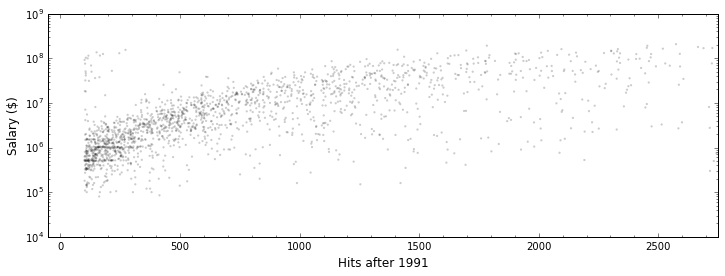

In [90]:
plt.figure(figsize=(12, 4))
plt.scatter(all_stats.Hits, all_stats.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
plt.yscale("log")
plt.xlabel("Hits after 1991", fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
plt.minorticks_on()
plt.xlim(-50, 2750)
plt.show()

## Univariate Linear Regression Model

Now that we have a basic visualization of our data, we will find the best linear regression model to fit this data using Kfold.

In [91]:


kfolds = cv.KFold(len(all_stats), n_folds=10)

regression = linear_model.LinearRegression()
xvals = np.array(all_stats.Hits)[:, np.newaxis]
yvals = np.array(all_stats.salary)

slopes, intercepts = [], []

for train, test in kfolds:
    x_train, x_test = xvals[train], xvals[test]
    y_train, y_test = yvals[train], yvals[test]
    regression.fit(x_train, y_train)
    slopes.append(regression.coef_)
    intercepts.append(regression.intercept_)

slope = np.mean(slopes)
intercept = np.mean(intercepts)

regression.coef_ = slope
regression.intercept_ = intercept

print("Our model is:\n\tSalary = {0:.2f} x N_Hits + ({1:.2f})".format(slope, intercept))

Our model is:
	Salary = 27286.44 x N_Hits + (-4947209.92)


### Plotting the Linear Regression Model on the Age, Salary Scatterplot

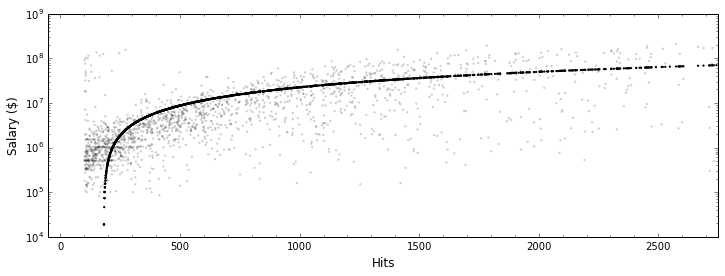

In [92]:
plt.figure(figsize=(12, 4))
plt.scatter(all_stats.Hits, all_stats.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
plt.scatter(xvals, regression.predict(xvals), edgecolor="None", s=5, c="k")
plt.yscale("log")
plt.xlabel("Hits", fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
plt.minorticks_on()
plt.xlim(-50, 2750)
plt.show()

In [94]:
print(
    "Our data is not represented by the linear regression model.\n",
    "Score: {}".format(regression.score(xvals, yvals))
     )

Our data is not represented by the linear regression model.
 Score: 0.3619612262357612


## Lesson: Don't use Linear Regression.
## ==============================


## Multivariate Linear Regression


In [108]:
N_folds = 10
kfolds = cv.KFold(len(all_stats), n_folds=N_folds)

regression = linear_model.LinearRegression()
valid_data = ["Runs", "Hits", "Caught_Stealing", "Base_on_Balls",]
xvals = np.array(all_stats[valid_data])
yvals = np.array(all_stats.salary)

coeffs, intercepts = [], []

for train, test in kfolds:
    x_train, x_test = xvals[train], xvals[test]
    y_train, y_test = yvals[train], yvals[train]
    regression.fit(x_train, y_train)
    coeffs.append(regression.coef_)
    intercepts.append(regression.intercept_)
    
coeffs = np.array(coeffs).mean(axis=0)
intercepts = np.array(intercepts).mean(axis=0)

regression.coef_ = coeffs
regression.intercept_ = intercepts


print("Score: {}".format(regression.score(xvals, yvals)))

Score: 0.5496265668736894


### Our score is substantially better using our multivariate model.

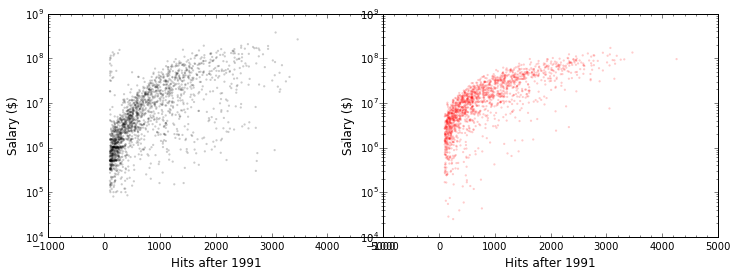

In [117]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0)
ax = plt.subplot(121)
ax.scatter(all_stats.Hits, all_stats.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel("Hits after 1991", fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
ax.minorticks_on()
ax = plt.subplot(122)
ax.scatter(xvals.T[1], regression.predict(xvals), edgecolor="None",
            s=5, c='r', alpha=0.2)
ax.set_yscale("log")
ax.set_ylim(10000, 1e9)
ax.set_xlabel("Hits after 1991", fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
ax.minorticks_on()
plt.show()